## NN Adv Assignment

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [34]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [35]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [36]:
train['label'].nunique()

10

In [37]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [38]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

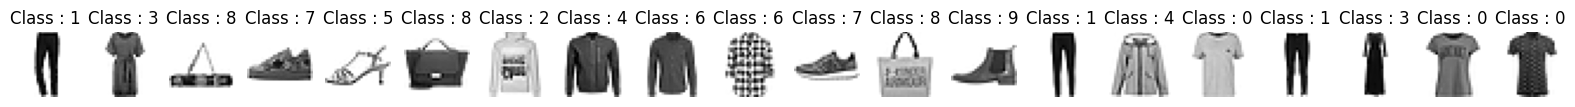

In [39]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [40]:
X_test = test.values

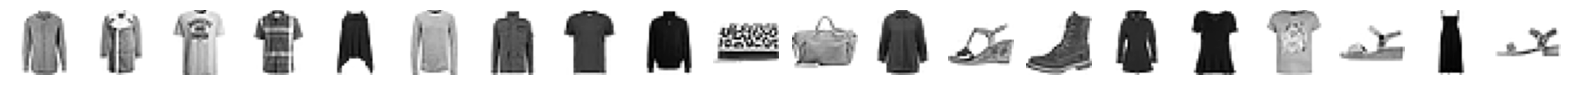

In [41]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [43]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [44]:
BATCH_SIZE = 128
EPOCHS = 15

In [45]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [46]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [47]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

## Case 1

1) Linear Size: 784 -> 512 -> 256 -> 128 -> 10
2) Act & Init: 전층 ReLU 및 He init
3) Norm: BatchNorm
4) DropOut: 0.2
5) Optimizer: Adam

In [48]:
class MyNet1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(128, 10),
            nn.ReLU()
        )

    def _init_weight_(self):
        #여기에 각 layer마다.. weight initialization.
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
            
        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x
    
model = MyNet1().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.7577, 	Train Accuracy: 72.83 %, 	Val Loss: 0.6301, 	Val Accuracy: 76.23 % 

[EPOCH: 2], 	Train Loss: 0.6378, 	Train Accuracy: 76.28 %, 	Val Loss: 0.5924, 	Val Accuracy: 77.84 % 

[EPOCH: 3], 	Train Loss: 0.5972, 	Train Accuracy: 77.51 %, 	Val Loss: 0.5683, 	Val Accuracy: 78.69 % 

[EPOCH: 4], 	Train Loss: 0.5762, 	Train Accuracy: 78.42 %, 	Val Loss: 0.5686, 	Val Accuracy: 78.38 % 

[EPOCH: 5], 	Train Loss: 0.3773, 	Train Accuracy: 86.18 %, 	Val Loss: 0.3164, 	Val Accuracy: 88.47 % 

[EPOCH: 6], 	Train Loss: 0.3148, 	Train Accuracy: 88.48 %, 	Val Loss: 0.3402, 	Val Accuracy: 87.82 % 

[EPOCH: 7], 	Train Loss: 0.3034, 	Train Accuracy: 88.86 %, 	Val Loss: 0.3088, 	Val Accuracy: 88.71 % 

[EPOCH: 8], 	Train Loss: 0.2869, 	Train Accuracy: 89.34 %, 	Val Loss: 0.3515, 	Val Accuracy: 87.37 % 

[EPOCH: 9], 	Train Loss: 0.2794, 	Train Accuracy: 89.55 %, 	Val Loss: 0.2957, 	Val Accuracy: 89.03 % 

[EPOCH: 10], 	Train Loss: 0.2702, 	Train Accuracy: 90.08 %, 	Val Loss: 0.

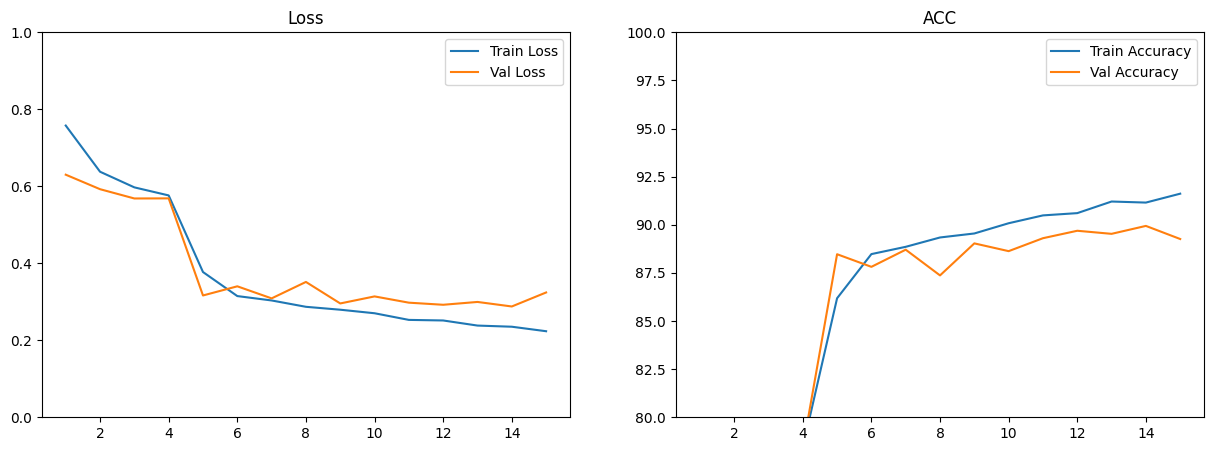

In [49]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## Case 2

1) Linear Size: 784 -> 392 -> 196 -> 98 -> 49 -> 10
2) Act & Init: 전층 ReLU 및 He init
3) Norm: BatchNorm
4) DropOut: 0.2
5) Optimizer: Adam

In [50]:
class MyNet2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(392, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(196, 98),
            nn.BatchNorm1d(98),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(98, 49),
            nn.BatchNorm1d(49),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear5 = nn.Sequential(
            nn.Linear(49, 10),
            nn.ReLU()
        )

    def _init_weight_(self):
        #여기에 각 layer마다.. weight initialization.
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
            
        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear4:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x
    
model2 = MyNet2().to(DEVICE)
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.6293, 	Train Accuracy: 78.33 %, 	Val Loss: 0.4288, 	Val Accuracy: 84.54 % 

[EPOCH: 2], 	Train Loss: 0.4602, 	Train Accuracy: 83.99 %, 	Val Loss: 0.3647, 	Val Accuracy: 86.66 % 

[EPOCH: 3], 	Train Loss: 0.4166, 	Train Accuracy: 85.38 %, 	Val Loss: 0.3732, 	Val Accuracy: 86.31 % 

[EPOCH: 4], 	Train Loss: 0.3861, 	Train Accuracy: 86.31 %, 	Val Loss: 0.3512, 	Val Accuracy: 87.04 % 

[EPOCH: 5], 	Train Loss: 0.3620, 	Train Accuracy: 87.17 %, 	Val Loss: 0.3492, 	Val Accuracy: 87.21 % 

[EPOCH: 6], 	Train Loss: 0.3515, 	Train Accuracy: 87.51 %, 	Val Loss: 0.3232, 	Val Accuracy: 88.16 % 

[EPOCH: 7], 	Train Loss: 0.3334, 	Train Accuracy: 88.06 %, 	Val Loss: 0.3159, 	Val Accuracy: 88.19 % 

[EPOCH: 8], 	Train Loss: 0.3214, 	Train Accuracy: 88.61 %, 	Val Loss: 0.3103, 	Val Accuracy: 88.69 % 

[EPOCH: 9], 	Train Loss: 0.3091, 	Train Accuracy: 88.92 %, 	Val Loss: 0.2892, 	Val Accuracy: 89.42 % 

[EPOCH: 10], 	Train Loss: 0.2977, 	Train Accuracy: 89.31 %, 	Val Loss: 0.

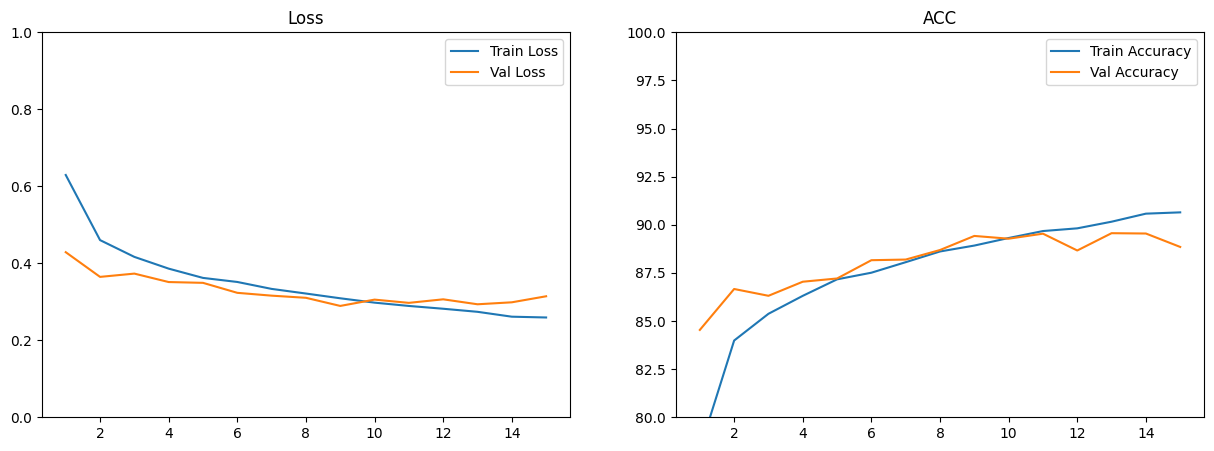

In [51]:
result2_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model2, train_loader)
  val_loss, val_accuracy = evaluate(model2, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result2 = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result2_list.append(result2)
result2_df = pd.DataFrame(result2_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result2_df['EPOCH'], result2_df['Train Loss'], label='Train Loss')
axes[0].plot(result2_df['EPOCH'], result2_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result2_df['EPOCH'], result2_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result2_df['EPOCH'], result2_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## Case 3

1) Linear Size: 784 -> 392 -> 196 -> 98 -> 49 -> 10
2) Act & Init: 전층 ReLU 및 He init
3) Norm: BatchNorm
4) DropOut: 0.3
5) Optimizer: Adam

In [53]:
class MyNet3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(392, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(196, 98),
            nn.BatchNorm1d(98),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(98, 49),
            nn.BatchNorm1d(49),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.linear5 = nn.Sequential(
            nn.Linear(49, 10),
            nn.ReLU()
        )

    def _init_weight_(self):
        #여기에 각 layer마다.. weight initialization.
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
            
        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear4:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x
    
model3 = MyNet3().to(DEVICE)
optimizer = torch.optim.Adam(model3.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.8920, 	Train Accuracy: 67.36 %, 	Val Loss: 0.6483, 	Val Accuracy: 74.97 % 

[EPOCH: 2], 	Train Loss: 0.7111, 	Train Accuracy: 73.56 %, 	Val Loss: 0.6235, 	Val Accuracy: 75.51 % 

[EPOCH: 3], 	Train Loss: 0.6744, 	Train Accuracy: 74.79 %, 	Val Loss: 0.6087, 	Val Accuracy: 76.28 % 

[EPOCH: 4], 	Train Loss: 0.6419, 	Train Accuracy: 75.93 %, 	Val Loss: 0.5676, 	Val Accuracy: 77.87 % 

[EPOCH: 5], 	Train Loss: 0.6251, 	Train Accuracy: 76.39 %, 	Val Loss: 0.5494, 	Val Accuracy: 78.00 % 

[EPOCH: 6], 	Train Loss: 0.6058, 	Train Accuracy: 77.30 %, 	Val Loss: 0.5523, 	Val Accuracy: 78.26 % 

[EPOCH: 7], 	Train Loss: 0.5967, 	Train Accuracy: 77.46 %, 	Val Loss: 0.5423, 	Val Accuracy: 78.18 % 

[EPOCH: 8], 	Train Loss: 0.5834, 	Train Accuracy: 77.89 %, 	Val Loss: 0.5364, 	Val Accuracy: 79.09 % 

[EPOCH: 9], 	Train Loss: 0.5753, 	Train Accuracy: 78.08 %, 	Val Loss: 0.5327, 	Val Accuracy: 79.32 % 

[EPOCH: 10], 	Train Loss: 0.5628, 	Train Accuracy: 78.61 %, 	Val Loss: 0.

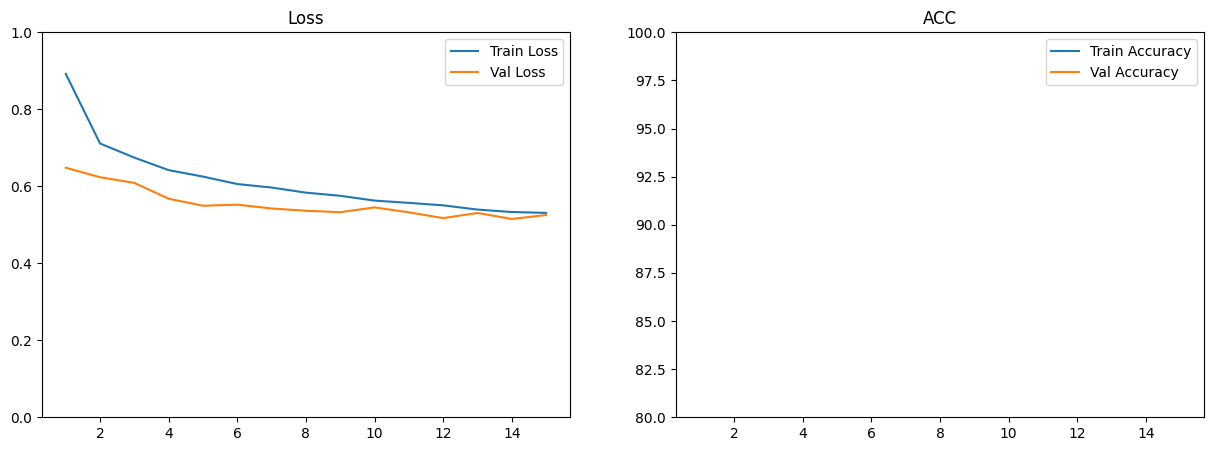

In [54]:
result3_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model3, train_loader)
  val_loss, val_accuracy = evaluate(model3, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result3 = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result3_list.append(result3)
result3_df = pd.DataFrame(result3_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result3_df['EPOCH'], result3_df['Train Loss'], label='Train Loss')
axes[0].plot(result3_df['EPOCH'], result3_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result3_df['EPOCH'], result3_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result3_df['EPOCH'], result3_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## Case 4

1) Linear Size: 784 -> 392 -> 196 -> 98 -> 49 -> 10
2) Act & Init: 처음 2개 층은 ReLU 및 He init, 그 후론 Sigmoid 및 Xavier init
3) Norm: BatchNorm
4) DropOut: 0.2
5) Optimizer: Adam

In [61]:
class MyNet4(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(392, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(196, 98),
            nn.BatchNorm1d(98),
            nn.Sigmoid(),
            nn.Dropout(0.2)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(98, 49),
            nn.BatchNorm1d(49),
            nn.Sigmoid(),
            nn.Dropout(0.2)
        )
        self.linear5 = nn.Sequential(
            nn.Linear(49, 10),
            nn.Sigmoid()
        )

    def _init_weight_(self):
        #여기에 각 layer마다.. weight initialization.
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
            
        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        for m in self.linear4:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x
    
model4 = MyNet4().to(DEVICE)
optimizer = torch.optim.Adam(model4.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 1.6938, 	Train Accuracy: 71.65 %, 	Val Loss: 1.5939, 	Val Accuracy: 75.93 % 

[EPOCH: 2], 	Train Loss: 1.5994, 	Train Accuracy: 76.54 %, 	Val Loss: 1.5821, 	Val Accuracy: 79.19 % 

[EPOCH: 3], 	Train Loss: 1.5833, 	Train Accuracy: 79.42 %, 	Val Loss: 1.5651, 	Val Accuracy: 82.40 % 

[EPOCH: 4], 	Train Loss: 1.5739, 	Train Accuracy: 82.34 %, 	Val Loss: 1.5658, 	Val Accuracy: 84.97 % 

[EPOCH: 5], 	Train Loss: 1.5641, 	Train Accuracy: 84.12 %, 	Val Loss: 1.5504, 	Val Accuracy: 86.29 % 

[EPOCH: 6], 	Train Loss: 1.5606, 	Train Accuracy: 84.56 %, 	Val Loss: 1.5502, 	Val Accuracy: 85.50 % 

[EPOCH: 7], 	Train Loss: 1.5581, 	Train Accuracy: 84.59 %, 	Val Loss: 1.5430, 	Val Accuracy: 86.87 % 

[EPOCH: 8], 	Train Loss: 1.5552, 	Train Accuracy: 85.06 %, 	Val Loss: 1.5494, 	Val Accuracy: 86.05 % 

[EPOCH: 9], 	Train Loss: 1.5538, 	Train Accuracy: 84.96 %, 	Val Loss: 1.5463, 	Val Accuracy: 86.64 % 

[EPOCH: 10], 	Train Loss: 1.5525, 	Train Accuracy: 84.92 %, 	Val Loss: 1.

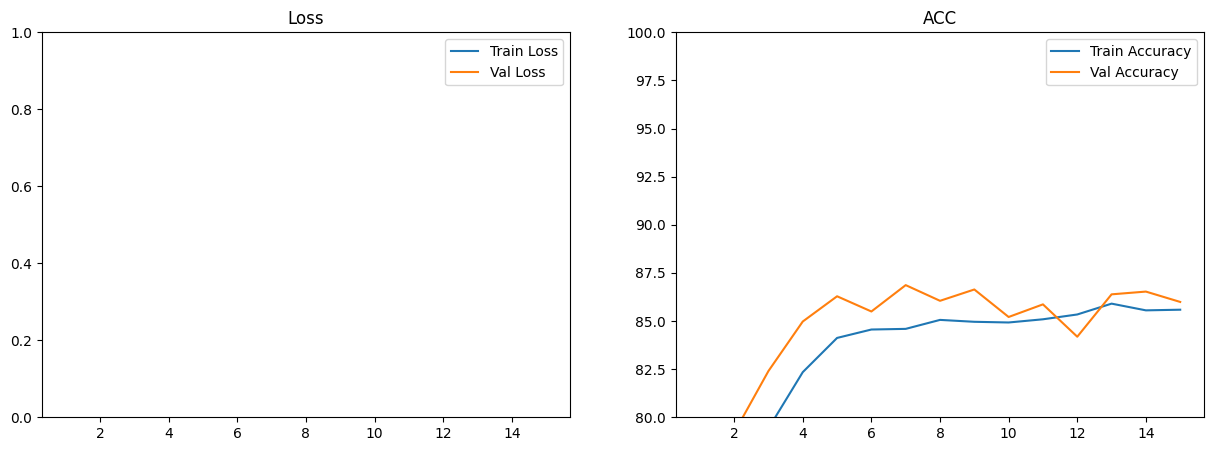

In [62]:
result4_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model4, train_loader)
  val_loss, val_accuracy = evaluate(model4, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result4 = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result4_list.append(result4)
result4_df = pd.DataFrame(result4_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result4_df['EPOCH'], result4_df['Train Loss'], label='Train Loss')
axes[0].plot(result4_df['EPOCH'], result4_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result4_df['EPOCH'], result4_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result4_df['EPOCH'], result4_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## Case 5

1) Linear Size: 784 -> 392 -> 196 -> 98 -> 49 -> 10
2) Act & Init: 전층 ReLU 및 He init
3) Norm: BatchNorm
4) DropOut: 0.2
5) Optimizer: Adam, Learning Rate : 0.005

In [66]:
class MyNet5(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(392, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(196, 98),
            nn.BatchNorm1d(98),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(98, 49),
            nn.BatchNorm1d(49),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear5 = nn.Sequential(
            nn.Linear(49, 10),
            nn.ReLU()
        )

    def _init_weight_(self):
        #여기에 각 layer마다.. weight initialization.
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
            
        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear4:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x
    
model5 = MyNet5().to(DEVICE)
optimizer = torch.optim.Adam(model5.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.9500, 	Train Accuracy: 69.56 %, 	Val Loss: 0.7860, 	Val Accuracy: 73.38 % 

[EPOCH: 2], 	Train Loss: 0.8332, 	Train Accuracy: 72.36 %, 	Val Loss: 0.7670, 	Val Accuracy: 73.91 % 

[EPOCH: 3], 	Train Loss: 0.7946, 	Train Accuracy: 73.31 %, 	Val Loss: 0.7489, 	Val Accuracy: 74.21 % 

[EPOCH: 4], 	Train Loss: 0.7746, 	Train Accuracy: 73.82 %, 	Val Loss: 0.7397, 	Val Accuracy: 74.42 % 

[EPOCH: 5], 	Train Loss: 0.7593, 	Train Accuracy: 74.24 %, 	Val Loss: 0.7329, 	Val Accuracy: 74.66 % 

[EPOCH: 6], 	Train Loss: 0.7457, 	Train Accuracy: 74.50 %, 	Val Loss: 0.7426, 	Val Accuracy: 74.33 % 

[EPOCH: 7], 	Train Loss: 0.7351, 	Train Accuracy: 74.62 %, 	Val Loss: 0.7126, 	Val Accuracy: 74.92 % 

[EPOCH: 8], 	Train Loss: 0.7247, 	Train Accuracy: 74.92 %, 	Val Loss: 0.7345, 	Val Accuracy: 74.39 % 

[EPOCH: 9], 	Train Loss: 0.7125, 	Train Accuracy: 75.18 %, 	Val Loss: 0.7228, 	Val Accuracy: 74.93 % 

[EPOCH: 10], 	Train Loss: 0.7068, 	Train Accuracy: 75.26 %, 	Val Loss: 0.

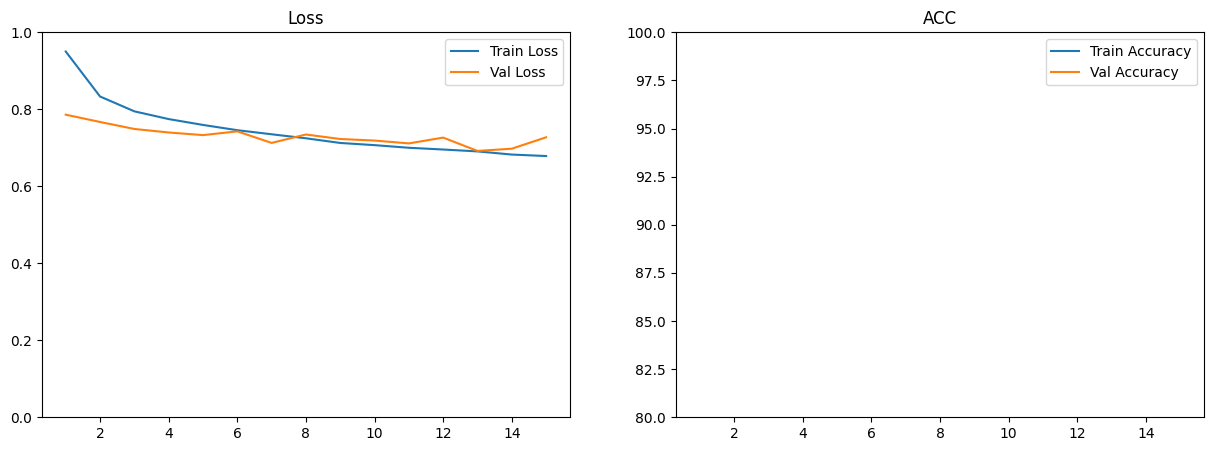

In [67]:
result5_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model5, train_loader)
  val_loss, val_accuracy = evaluate(model5, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result5 = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result5_list.append(result5)
result5_df = pd.DataFrame(result5_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result5_df['EPOCH'], result5_df['Train Loss'], label='Train Loss')
axes[0].plot(result5_df['EPOCH'], result5_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result5_df['EPOCH'], result5_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result5_df['EPOCH'], result5_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [ ]:
'''
결론:

초반 15에포크까지 모델의 Validation Accuracy를 기준으로 성능을 평가할 때,
가장 성능이 높은 모델은 Case2의 'MyNet2'이다.

Optimizer로 Adam을 쓴 것, 그리고 계층을 한 층 더 deep하게 만든 것이
BaseLine 모델에 비하여 성능을 향상시키는 데 주효했다.

DropOut 비율은 0.2일 때 성능이 좋았으며, 비율을 0.3으로 높이면 성능이 감소했다.
초기 에포크에서는 learning rate가 0.01로, 0.005일 때에 비해 비교적 큰 값일 때 학습 속도가 빠르게 향상되었다.
이로부터 비교적 모델의 크기가 작을 때 DropOut 비율을 너무 키우면 정보 손실이 커진다는 것,
Learning Rate는 초기엔 커야 Optimization이 빠르게 일어날 것임을 추측할 수 있다.
'''